# ML Projet Part II (Received Calls)
**Jie ZHENG ** <br>
**Yunzhi BAI** <br>
<br>
<br>
<br>
**This part is for the real dataset: In AXA, the number of received calls (by 30 minutes) from a given assignment **<br>
<br>
**To run this part, please run it "step by step"! In the sections of "Training", there are many models provided, please just run one chosen model at one time.** <br>
**For example: To use randomForest, just run the cells in the section "RandomForest". Then, do not run cells in other sections anymore!**
<br><br>
**IMPORTANT: There are other parts (for different datasets) in the directory.**

# 1. Preprocessing

## 1.1 Load Data

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv('train_24.csv', sep=';')
#df = pd.read_csv('train_27.csv', sep=';')

In [3]:
print df.shape
df.head()

(47516, 2)


,DATE,sum_RECEIVED_CALLS
0,2011-01-01 00:00:00.000,0
1,2011-01-01 00:30:00.000,0
2,2011-01-01 01:00:00.000,0
3,2011-01-01 01:30:00.000,0
4,2011-01-01 02:00:00.000,0


## 1.2 Define functions and dictionaries

In [4]:
options_weekdays = {'Monday' : 1,
            'Tuesday' : 2,
            'Wednesday' : 3,
            'Thursday' : 4,
            'Friday' : 5,
            'Saturday' : 6,
            'Sunday' : 7,
}


options_weekend = {'Monday' : 0,
            'Tuesday' : 0,
            'Wednesday' : 0,
            'Thursday' : 0,
            'Friday' : 0,
            'Saturday' : 1,
            'Sunday' : 1,
}

options_weekdays_fr = {'Lundi' : 1,
            'Mardi' : 2,
            'Mercredi' : 3,
            'Jeudi' : 4,
            'Vendredi' : 5,
            'Samedi' : 6,
            'Dimanche' : 7,
}

nuit_jours = {'Nuit':0,'Jours':1}

In [5]:
import datetime

# to construct features about date
def gettime(dataframe):
    df = dataframe.copy()
    df['Year'] = pd.DatetimeIndex(df['DATE']).year
    df['Month'] = pd.DatetimeIndex(df['DATE']).month
    df['Day'] = pd.DatetimeIndex(df['DATE']).day
    n = len(df)
    for i in np.arange(n):
        tmp = df.ix[i].DATE
        weekday = datetime.datetime.strptime(tmp, '%Y-%m-%d %H:%M:%S.%f').strftime('%A')
        hour = '{d.hour}'.format(d=datetime.datetime.strptime(tmp, '%Y-%m-%d %H:%M:%S.%f'))
        minute = datetime.datetime.strptime(tmp, '%Y-%m-%d %H:%M:%S.%f').strftime('%M')
        df.set_value(i, 'DAY_WE_DS', options_weekdays[weekday])
        df.set_value(i, 'WEEK_END', options_weekend[weekday])
        df.set_value(i, 'TPER_HOUR', hour+minute)
        if (int(hour)>=8 and int(hour)<=22) or (int(hour)==7 and int(minute)==30) or (int(hour)==23 and int(minute)==0):
            df.set_value(i, 'TPER_TEAM', 1)
        else: df.set_value(i, 'TPER_TEAM', 0)
    return df
     
# 07:30:00.000 Jours 
# 23:30:00.000 Nuit

In [6]:
from pandas import DataFrame

def addMeanValues(df_train, byDAY_WE_DS=True, byDAY=True, byMonth=True, byHour=True, byTEAM=True, byYear=True):
    df = df_train.copy()
    if byDAY_WE_DS:
        df_meanByDAY_WE_DS = DataFrame({'meanByDAY_WE_DS':df.groupby(['DAY_WE_DS'])['sum_RECEIVED_CALLS'].mean()}).reset_index()
        df = df.join(df_meanByDAY_WE_DS.set_index('DAY_WE_DS'),on='DAY_WE_DS')
    if byDAY:
        df_meanByDAY = DataFrame({'meanByDay':df.groupby(['Day'])['sum_RECEIVED_CALLS'].mean()}).reset_index()
        df = df.join(df_meanByDAY.set_index('Day'),on='Day')
    if byMonth:
        df_meanByMONTH = DataFrame({'meanByMonth':df.groupby(['Month'])['sum_RECEIVED_CALLS'].mean()}).reset_index()
        df = df.join(df_meanByMONTH.set_index('Month'),on='Month')
    if byHour:
        df_meanByHour = DataFrame({'meanByHour':df.groupby(['TPER_HOUR'])['sum_RECEIVED_CALLS'].mean()}).reset_index()
        df = df.join(df_meanByHour.set_index('TPER_HOUR'),on='TPER_HOUR')
    if byTEAM:
        df_meanByTEAM = DataFrame({'meanByTEAM':df.groupby(['TPER_TEAM'])['sum_RECEIVED_CALLS'].mean()}).reset_index()
        df = df.join(df_meanByTEAM.set_index('TPER_TEAM'),on='TPER_TEAM')
    if byYear:
        df_meanByYear = DataFrame({'meanByYear':df.groupby(['Year'])['sum_RECEIVED_CALLS'].mean()}).reset_index()
        df = df.join(df_meanByYear.set_index('Year'),on='TPER_TEAM')   
    return df

## 1.3 Construct features about time for dataset

In [7]:
df_v0 = gettime(df)
df_v0.head(5)

,DATE,sum_RECEIVED_CALLS,Year,Month,Day,DAY_WE_DS,WEEK_END,TPER_HOUR,TPER_TEAM
0,2011-01-01 00:00:00.000,0,2011,1,1,6,1,000,0
1,2011-01-01 00:30:00.000,0,2011,1,1,6,1,030,0
2,2011-01-01 01:00:00.000,0,2011,1,1,6,1,100,0
3,2011-01-01 01:30:00.000,0,2011,1,1,6,1,130,0
4,2011-01-01 02:00:00.000,0,2011,1,1,6,1,200,0


## 1.4 Add statistic information (average received calls), use OneHotEncoder

In [8]:
listToEncoder = ['DAY_WE_DS','TPER_HOUR']

df_v1 = addMeanValues(df_v0, byDAY_WE_DS=True, byDAY=True, byMonth=True, byHour=True, byTEAM=True, byYear=False)
df_v1 = df_v1[['WEEK_END','DAY_WE_DS','TPER_TEAM','TPER_HOUR','Year','Month','Day','meanByDAY_WE_DS','meanByDay','meanByMonth','meanByHour','meanByTEAM','sum_RECEIVED_CALLS']]
df_v1 = pd.get_dummies(df_v1,columns=listToEncoder)

df_v1.head()

,WEEK_END,TPER_TEAM,Year,Month,Day,meanByDAY_WE_DS,meanByDay,meanByMonth,meanByHour,meanByTEAM,...,TPER_HOUR_500,TPER_HOUR_530,TPER_HOUR_600,TPER_HOUR_630,TPER_HOUR_700,TPER_HOUR_730,TPER_HOUR_800,TPER_HOUR_830,TPER_HOUR_900,TPER_HOUR_930
0,1,0,2011,1,1,53.055677,51.851807,55.419034,2.653968,1.901925,...,0,0,0,0,0,0,0,0,0,0
1,1,0,2011,1,1,53.055677,51.851807,55.419034,2.353814,1.901925,...,0,0,0,0,0,0,0,0,0,0
2,1,0,2011,1,1,53.055677,51.851807,55.419034,1.956476,1.901925,...,0,0,0,0,0,0,0,0,0,0
3,1,0,2011,1,1,53.055677,51.851807,55.419034,1.725532,1.901925,...,0,0,0,0,0,0,0,0,0,0
4,1,0,2011,1,1,53.055677,51.851807,55.419034,1.370607,1.901925,...,0,0,0,0,0,0,0,0,0,0


# 2. Training

## 2.1 RandomForest

In [9]:
y = df_v1.sum_RECEIVED_CALLS.values
X = df_v1.drop('sum_RECEIVED_CALLS',axis=1).values

In [10]:
from sklearn.ensemble import RandomForestRegressor
randomForest = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1, n_jobs=-1)   
randomForest.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [11]:
y_pred = randomForest.predict(X)

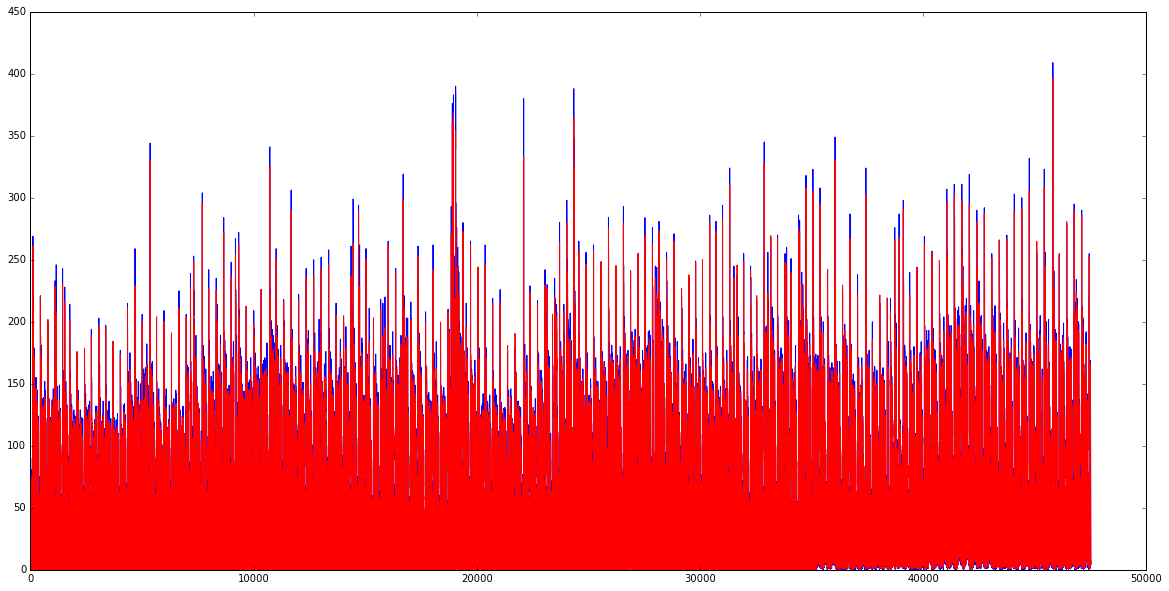

In [12]:
plt.figure(figsize=(20,10))
plt.plot(y)
plt.plot(y_pred,'r')
plt.show()

In [13]:
print "RMSE: "+ str(np.sqrt(sum((y_pred-y)**2)/len(y)))

RMSE: 4.98906188141


## 2.2 Time Series

### 2.2.1 Load and transform data

In [14]:
df = pd.read_csv('train_24.csv', sep=';')
df.head()

,DATE,sum_RECEIVED_CALLS
0,2011-01-01 00:00:00.000,0
1,2011-01-01 00:30:00.000,0
2,2011-01-01 01:00:00.000,0
3,2011-01-01 01:30:00.000,0
4,2011-01-01 02:00:00.000,0


In [15]:
def transform1(dataframe):
    df = dataframe.copy()
    df.sum_RECEIVED_CALLS = df.sum_RECEIVED_CALLS.astype(float)
    n = len(df)
    for i in np.arange(n):
        tmp1 = df.ix[i].DATE
        tmp2 = pd.datetime.strptime(tmp1, '%Y-%m-%d %H:%M:%S.%f')
        df.set_value(i, 'DATE', tmp2)
    return df.set_index('DATE')

In [16]:
df_v1 = transform1(df)
df_v1.head()

,sum_RECEIVED_CALLS
DATE,
2011-01-01 00:00:00,0
2011-01-01 00:30:00,0
2011-01-01 01:00:00,0
2011-01-01 01:30:00,0
2011-01-01 02:00:00,0


In [17]:
ts = df_v1['sum_RECEIVED_CALLS'].astype(float)

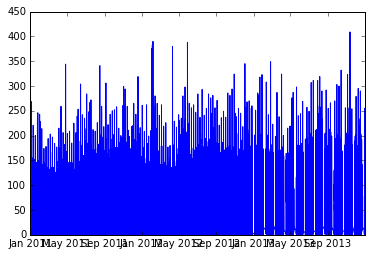

In [18]:
plt.plot(ts)

### 2.2.2 Test the stationarity

In [19]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=720)
    rolstd = pd.rolling_std(timeseries, window=720)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

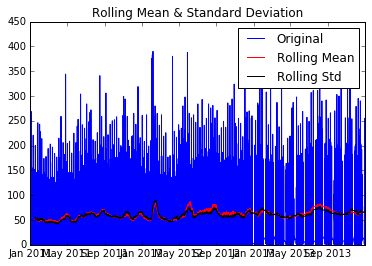

Results of Dickey-Fuller Test:
Test Statistic                   -25.849581
p-value                            0.000000
#Lags Used                        57.000000
Number of Observations Used    47458.000000
Critical Value (5%)               -2.861601
Critical Value (1%)               -3.430488
Critical Value (10%)              -2.566802
dtype: float64


In [20]:
test_stationarity(ts)

### 2.2.3 Determiner the parametors for ARIMA

In [21]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts, nlags=12)
lag_pacf = pacf(ts, nlags=12, method='ols')

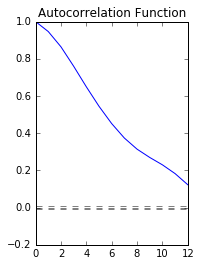

In [22]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

**We could get the theorical value of q from this figure. So we should try different values when training. <br>PS:We assume q = 1 and checked it works well**

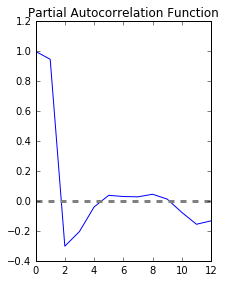

In [23]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

**p = 2**

### 2.2.4 Train ARIMA model

**order = (p, d, q)**

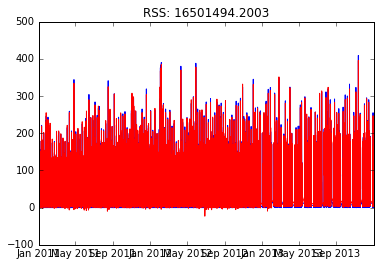

In [24]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts, order=(2, 0, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts)**2))

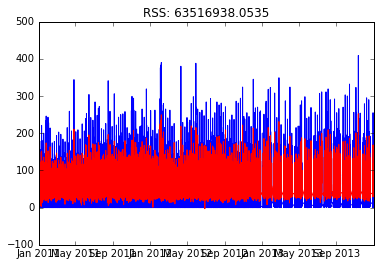

In [25]:
model = ARIMA(ts, order=(0, 0, 1))  
results_MA = model.fit(disp=-1)  
plt.plot(ts)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts)**2))

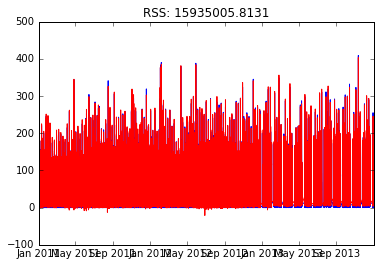

In [26]:
model = ARIMA(ts, order=(2, 0, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts)**2))

In [27]:
print "RMSE: "+ str(np.sqrt(sum((results_ARIMA.fittedvalues-ts)**2)/len(ts)))

RMSE: 18.3128600426
